# Colab データインストール

In [0]:
# 以下を実行すると、認証情報を取得するための許可を求められるので、許可してトークンを発行し、テキストボックスに貼り付ける。
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [0]:
# Colabにおいてデータを読みこむ。グーグルドライブをマウントします。その為に必要なパッケージを取得しておく。
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


In [0]:
# 以下実行により、今度は google-drive-ocamlfuse によるアクセスの許可を聞かれる。これも許可する。
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# 今回は指定したフォルダのみマウントする
!cp -f ~/.gdfuse/default/config config
!sed -i -e "s/^root_folder=$/root_folder=1FwGdPnKlcYYRe1mZGE5Ci-PWlIY8k5J7/" config
# 上記が正常に終われば、ようやくマウントが可能となる。
!mkdir -p drive
!google-drive-ocamlfuse -config ./config -cc drive
!ls drive

Clearing cache...done
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
compare-deeplibs.ipynb	    dataset	week3-EDA
dataマウントテンプレ.ipynb  test.ipynb	week4


In [3]:
# これ以降はターミナルと同様にディレクトリを扱える
cd drive/dataset

/content/drive/dataset


In [4]:
ls

Home Credit Default Risk/  Mercedes-Benz Greener Manufacturing/
House Prices_data/         Porto Seguro’s Safe Driver Prediction/
Instacart Market Basket/   Titanic/


In [5]:
cd Home Credit Default Risk

/content/drive/dataset/Home Credit Default Risk


In [6]:
ls

application_test.csv
application_train.csv
bureau_balance.csv
bureau.csv
credit_card_balance.csv
HomeCredit_columns_description.csv
HomeCredit_columns_description.ods
HomeCredit_columns_description.ods (59938948)
HomeCredit_columns_description.ods (9b521521)
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
sample_submission.csv
train_profile.html


# EDA：Home Credit Default Risk Competition

これからKaggeのコンペのEDAを行います。    
今回は**データ探索（EDA）**として、  
データがどのようなものか、どういった相関があるかなどを確認していきます  


それにより、今後の機械学習フローにおいて例えばデータの整形や、  
機械学習手法の決定に役立つことになります  
また、モデルの精度をあげる重要な特徴量を発見できるかもしれない  
言うなれば「**お宝探し**」の部分もあります。  


ここでは、どの機械学習においても行うであろう  
EDAの基本的な流れを行なっていきたいと思います。  

## Overview

まず簡単にこのコンペの概要をお伝えします。  

「各申請者がローンを返済できるかを予測する」これが今回の目標です。  
返済をちゃんとする、またはしないという2択の
機械学習においては「分類」の問題になります。  

この競技会の評価基準は、予測された確率と目標値との間のROC曲線の下の領域で評価されます。  
ROC曲線の詳細については[こちら](https://qiita.com/kenmatsu4/items/550b38f4fa31e9af6f4f)を引用させていただきます

そのほかの詳しいコンペの情報は[Home Credit Default Risk Competition](https://www.kaggle.com/c/home-credit-default-risk)を確認ください

## Imports

はじめに、必要なライブラリをインポートします

In [0]:
# pandas and numpy for data manipulation
import numpy as np
import pandas as pd 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

## Read in Data 

データセットのロードをします。  
また、そのデータの行と列の数を確認します。

In [10]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")
print("Train rows and columns : ", train.shape)
print("Test rows and columns : ", test.shape)

Train rows and columns :  (307511, 122)
Test rows and columns :  (48744, 121)


trainデータの中身を見てみましょう

In [11]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


このままでは全ての特徴量を確認することができませんね。  
途中が省略されてしまっています。

全ての特徴量を詳細に確認したい場合、  
『pandas_profiling』を利用すれば各特徴量のヒストグラムや欠損値の有無を表示できます  
ここでは紹介までにとどめます。大きいデータの処理には時間がかかるためと、  
今は一つ一つ情報をを取り出して見ていきたいためです。  
  


## categorical variables

最初に、どの特徴がカテゴリ変数なのか確認していきましょう。  
カテゴリ変数はモデルでの学習において不便なことが多いため把握しておきましょう

In [12]:
train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
FLAG_MOBIL                      int64
FLAG_EMP_PHONE                  int64
FLAG_WORK_PHONE                 int64
FLAG_CONT_MOBILE                int64
FLAG_PHONE  

これでどれが何のタイプか確認することができました。  
しかし「どのタイプがいくつ程あるのか」がすぐわかりませんね。  
もう少し直感的に理解できるようにグラフ化をしましょう。

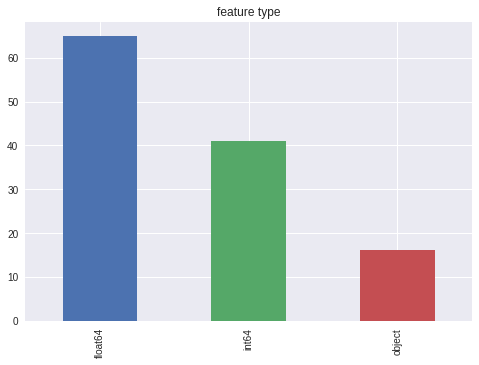

float64    65
int64      41
object     16
dtype: int64

In [13]:
train.dtypes.value_counts().plot.bar()
plt.title("feature type")
plt.show()

train.dtypes.value_counts()

うまくいきました！
カテゴリー変数は今回は行いませんが  
実際の機械学習フローの特徴量エンジニアリングの段階で処理を行うことになります。  

## Target variables

さて、私たちはまだ重要なことを確認していません。  
それは**目的変数（Target Variables）**です。  
コンペティションの要求がこの目的変数を「分類」するのか「回帰」するのか  
確認した上で、実際にtrainデータではどんな特徴があるか中身をみる必要があります    

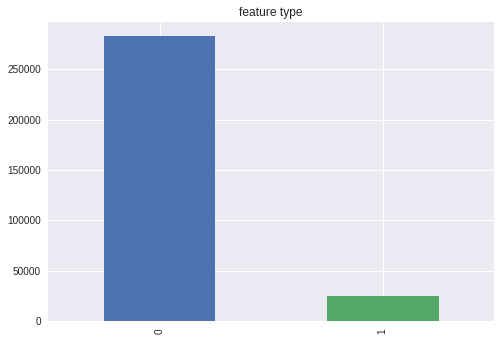

In [25]:
train['TARGET'].value_counts().plot.bar()
plt.title("feature type")
plt.show()

今回のコンペでは「分類」問題でしたね。そして「１」が問題あり、「０」が問題なし です。  

実際に見てみると、問題がある人というのはそうでない人と比べて数少ない存在というのが確認できます。  

また割合で視覚的に確認できるように円グラフを出してみます

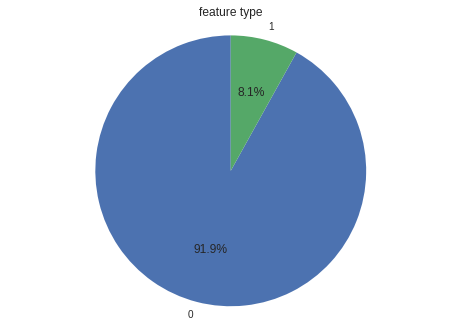

In [40]:
plt.title("feature type")
plt.pie(train['TARGET'].value_counts(), labels=['0', '1'], startangle=90 , autopct="%1.1f%%")
plt.axis('equal')
plt.show()

では次に、一般的な手法を用いて、欠損値の確認を行いたいと思います。

## Missing data

trainデータ内における欠損値を確認したいと思います。  
欠損値があると、そもそも機械学習モデルを動かせなかったりします。  


まずは簡単に、欠損値の含まれるカラムを上から15程みてみます

In [94]:
total_null = train.isnull().sum().sort_values()[::-1]
total_null[:15]

COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_AVG     213514
FONDKAPREMONT_MODE          210295
LIVINGAPARTMENTS_MEDI       210199
LIVINGAPARTMENTS_MODE       210199
LIVINGAPARTMENTS_AVG        210199
FLOORSMIN_MEDI              208642
FLOORSMIN_MODE              208642
FLOORSMIN_AVG               208642
YEARS_BUILD_MEDI            204488
YEARS_BUILD_AVG             204488
dtype: int64

非常に欠損が多いですね！  
これは割合で言うといくらなのか気になるので、見てみましょう

In [95]:
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values()[::-1]
missing_train_data  = pd.concat([total_null, percent], axis=1, keys=['total_null', 'Percent'])
missing_train_data.head(15)

,total_null,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


およそ70%の欠損があるデータがたくさんありますね。
これを視覚的にまとめてみてみましょう

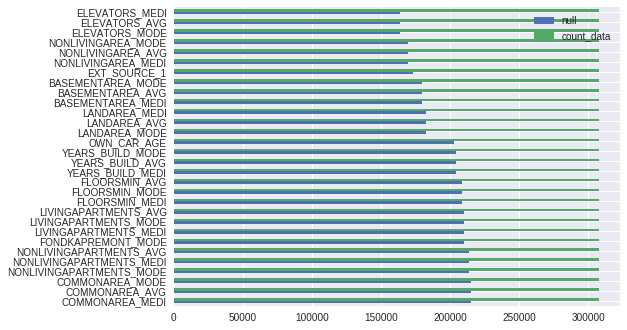

In [141]:
null = train.isnull().sum()
count_data = train.isnull().count()

null_train_data  = pd.concat([null, count_data], axis=1, keys=['null', 'count_data']).sort_values(by=['null'])[::-1]
plt.figure(figsize=(12,5))
null_train_data[:30].plot.barh()

この視覚化や数値としての欠損値確認は、  
欠損値を実際に処理した後にも重要です。  


## Data Exploration

これからいくつかの特徴量について直感的に傾向を捉えておきたいと思います。  
視覚化によって数値だけでは見えてこない重要な情報が見えることがあります  
  
では視覚化のためグラフをいくつか描いていきたいと思います。

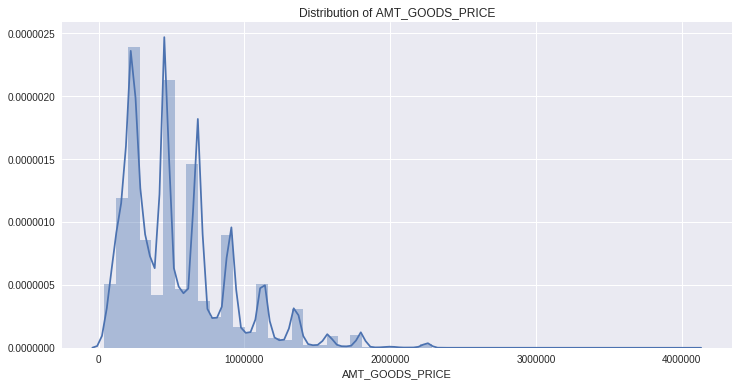

In [155]:
# Distribution of AMT_GOODS_PRICE (買った商品の価格)
plt.figure(figsize=(12,6))
plt.title("Distribution of AMT_GOODS_PRICE")
ax = sns.distplot(train["AMT_GOODS_PRICE"].dropna())

欠損値処理を簡単にdropna()でした後plotしています。  
distplotは1変数の分布を可視化することができます。  
山がおよそ一定間隔でいくつかできているのがわかります。  
これによって、その間隔の値段はローンに使われる可能性が高いと推測することができそうですね。  

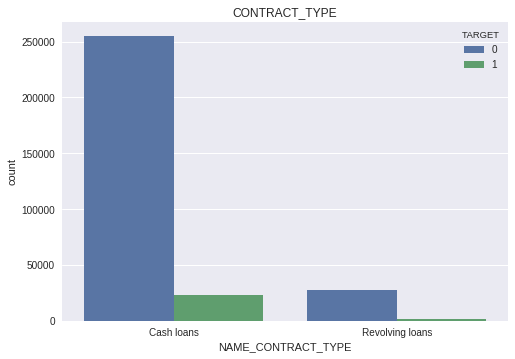

In [160]:
plt.title("CONTRACT_TYPE")
sns.countplot(x="NAME_CONTRACT_TYPE", hue="TARGET", data=train)

ローン返済に問題があるひとはリボ払いだろうと予想していましたが、  
実際にはそうとも言えなさそうですね。  


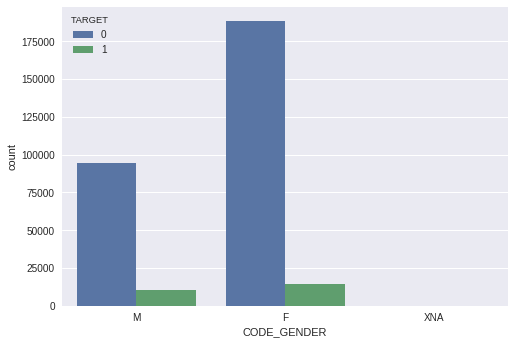

In [164]:
sns.countplot(x="CODE_GENDER", hue="TARGET", data=train)

男性と女性の差をみてみましたが、これを見る限り男性の方が  
ローン返済に問題を起こす可能性が少し高そうだとわかります。  

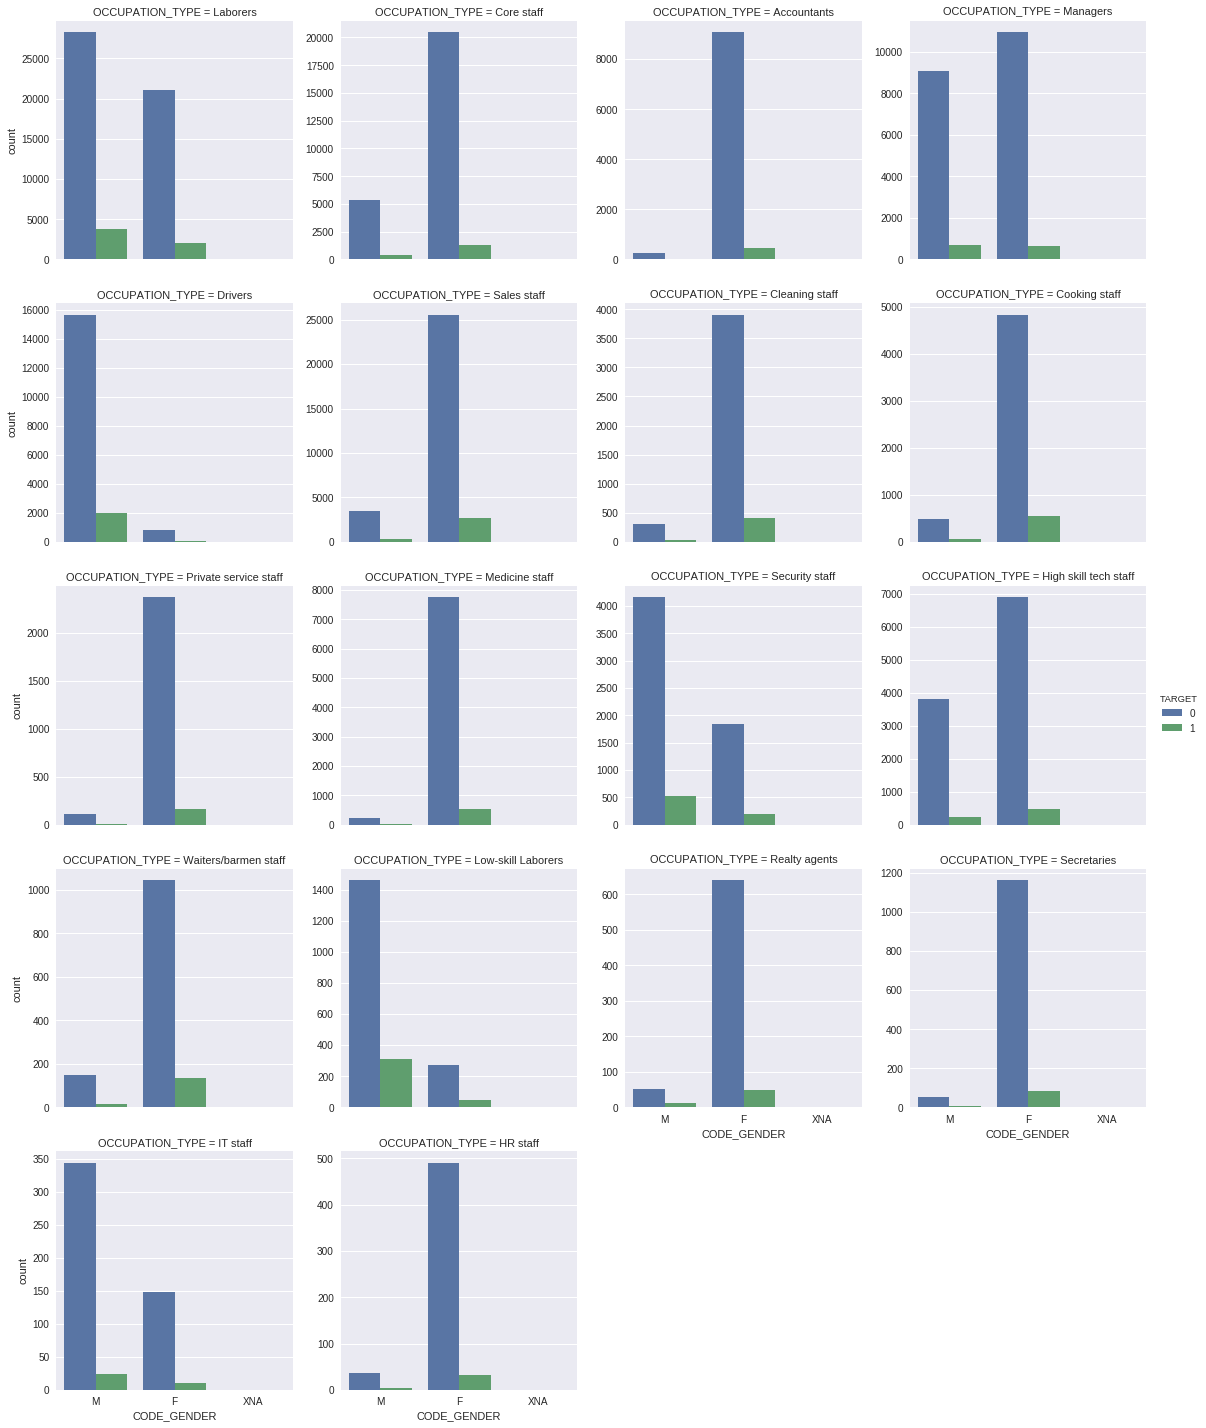

In [175]:
sns.factorplot(x="CODE_GENDER", hue="TARGET", col="OCCUPATION_TYPE", data=train, kind="count",col_wrap=4, sharey=False)
# col_wrap で行の値が4ごとに新しくなる
# sharey=False でyの値（count）軸がグラフごとに使われた数値分ずつ減る

col="OCCUPATION_TYPE"
カラムOCCUPATION_TYPEごとに、男女でのローン問題を可視化しています。  

このグラフからわかることは、  
Laborersと、low-skill Laborersの問題発生率が高いように見えますね。  
特にlow-skillが目立ちます。  

## Correlations

続いて相関関係を見ていきたいと思います  
特にターゲット変数との相関が重要になってきます。  
影響を与える変数というものこそ、使うべき変数や値であることが言えるからです  

In [0]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [202]:
# Calculate all correlations in dataframe
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
positive_correlations = pd.DataFrame(corrs['TARGET'].head(10))
positive_correlations

,TARGET
TARGET,1.000000
DAYS_BIRTH,0.078239
REGION_RATING_CLIENT_W_CITY,0.060893
REGION_RATING_CLIENT,0.058899
DAYS_LAST_PHONE_CHANGE,0.055218
DAYS_ID_PUBLISH,0.051457
REG_CITY_NOT_WORK_CITY,0.050994
FLAG_EMP_PHONE,0.045982
REG_CITY_NOT_LIVE_CITY,0.044395
FLAG_DOCUMENT_3,0.044346


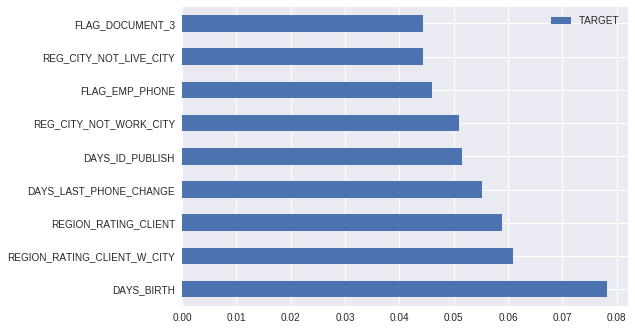

In [196]:
positive_correlations[1:].plot.barh()

こちらは正の相関です。  
DAYS_BIRTHがもっとも相関があることがわかります。  
傾向として、街の評価に関する変数が多いように見られますね。  
必要によっては深く見ていくことも検討できます。

In [203]:
# Ten most negative correlations
negative_correlations = pd.DataFrame(corrs['TARGET'].dropna().tail(10))
negative_correlations

,TARGET
ELEVATORS_AVG,-0.034199
REGION_POPULATION_RELATIVE,-0.037227
AMT_GOODS_PRICE,-0.039645
FLOORSMAX_MODE,-0.043226
FLOORSMAX_MEDI,-0.043768
FLOORSMAX_AVG,-0.044003
DAYS_EMPLOYED,-0.044932
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


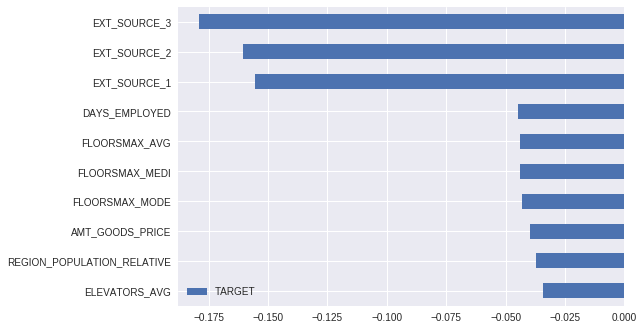

In [201]:
negative_correlations.plot.barh()

こちらは負の相関です。  
EXT_SOURCEというものがとても高い反応を示していますね。  
この変数は詳細が不明なため、説明はできないが良い結果を返すことが期待できますね。  
ほかの変数は理解しやすいです。  
部屋の大きさや勤務日数はお金持っているかどうかに関わりそうですよね。

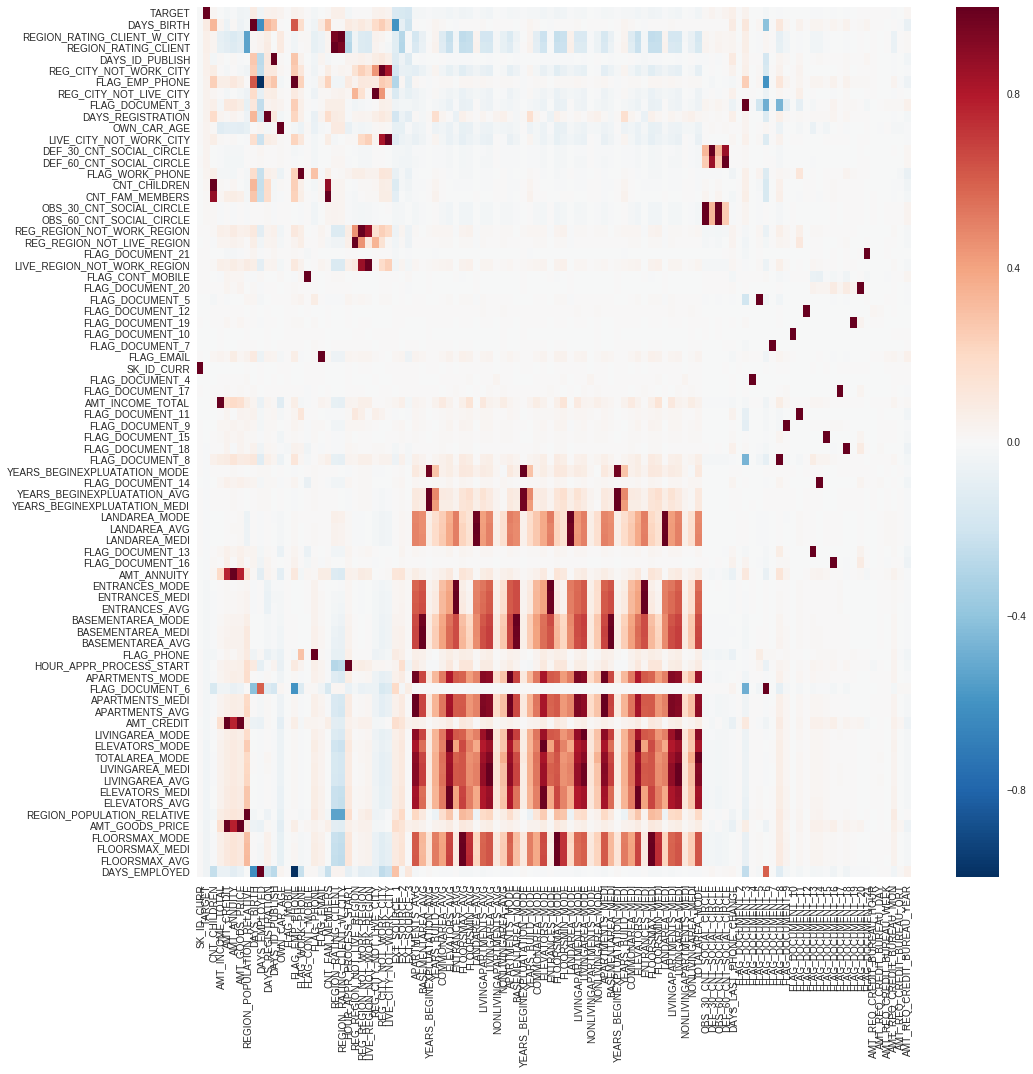

In [185]:
# Heatmap
plt.figure(figsize=(16,16))
sns.heatmap(corrs.dropna())

こちらはヒートマップです。  
今回は変数が多く、かつそのジャンルグループのようなものもありますよね  
ですので、そのグループはやはり塊として同じような相関を示すことがこれを見ることで確認できます。  
また、TARGET変数の全ての変数との相関も確認できるため大事なグラフになります！

## 最後に

ここまでのEDAで、今回のコンペで使われているデータについて  
それぞれの傾向が見えてきたのではないでしょうか。  
欠損値の確認やカテゴリー変数の確認はほかの作業の橋渡しになる部分です。  

グラフ化も、棒グラフやヒストグラム以外にも様々な表現があります。  
目的に応じたプロット方法を選べるように少しずつ慣れていきたいです。  